# Preprocess

> Functions to preprocess sequence to prepare kinase substrate dataset

## Setup

In [ ]:
#| default_exp utils

In [ ]:
#| export
import numpy as np, pandas as pd
from tqdm import tqdm
from katlas.data import *
from fastcore.meta import delegates
from pathlib import Path

# reactome
from pandas import json_normalize
from reactome2py import analysis
from matplotlib import pyplot as plt

# fasta
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO, AlignIO

In [ ]:
#| hide
from nbdev import show_doc

In [ ]:
#| hide
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 100) # show all columns

```python
from katlas.utils import *
```

## Commons

In [ ]:
#| export
def get_fasta(df,seq_col='kd_seq',id_col='kd_ID',path='out.fasta'):
    "Generate fasta file from sequences."
    records = [
        SeqRecord(Seq(row[seq_col]), id=row[id_col], description="")
        for _, row in df.iterrows()
    ]
    SeqIO.write(records, path, "fasta")
    print(len(records))

```python
get_fasta(kd,seq_col='kd_seq',id_col='kd_ID',path='raw/kinase_domains.fasta')
```

In [ ]:
#| export
def aln2df(fname):
    'Read .aln file from clustalo output into a dataframe'
    alignment = AlignIO.read(fname, "clustal")
    alignment_array = [list(str(record.seq)) for record in alignment]
    df = pd.DataFrame(alignment_array)
    df.columns = df.columns+1 # use amino acid index starting from 1
    return df

```python
df = aln2df("raw/kinase_domains.aln")
```

In [ ]:
#| export
def get_path(dir_path,fname):
    "Ensure the directory exists and return the full file path."
    dir_path = Path(dir_path).expanduser()
    dir_path.mkdir(parents=True,exist_ok=True)

    return dir_path/fname

```python
get_path('~/img/folder','test.svg')
```

In [ ]:
#| export
def get_diff(df1, df2, col1, col2=None):
    "Get non-overlap parts of two dataframes."
    if col2 is None:
        col2=col1
    df1_unique = df1[~df1[col1].isin(df2[col2])]
    df2_unique = df2[~df2[col2].isin(df1[col1])]
    return df1_unique, df2_unique

In [ ]:
df1 = pd.DataFrame({'gene': ['A', 'B', 'C']})
df2 = pd.DataFrame({'gene': ['B', 'C', 'D']})

df1_unq, df2_unq = get_diff(df1, df2, 'gene')

In [ ]:
df1_unq

,gene
0,A


In [ ]:
df2_unq

,gene
2,D


## Checker

In many phosphorylation datsets, there are amino acids in the site sequence that are in lower case but does not belong to s/t/y. Also, there are uncommon amino acids such as U or O that appear in the sequence. Therefore, it is essential to convert the sequence string for kinase ranking.

In [ ]:
#| export
def check_seq(seq):
    """Convert non-s/t/y characters to uppercase and replace disallowed characters with underscores."""
    acceptor = seq[len(seq) // 2]
    assert acceptor.lower() in {'s', 't', 'y'}, f"{seq} has {acceptor} at position {len(seq) // 2}; need to have one of 's', 't', or 'y' in the center"

    allowed_chars = set("PGACSTVILMFYWHKRQNDEsty")
    return "".join(char if char in {'s', 't', 'y'} else (char.upper() if char.upper() in allowed_chars else '_') for char in seq)

In [ ]:
try:
    check_seq('aaadaaa')
except Exception as e:
    print(e)

aaadaaa has d at position 3; need to have one of 's', 't', or 'y' in the center


In [ ]:
check_seq('AAkUuPSFstTH') # if the center amino acid does not belong to sty/STY, will raise an error

'AAK__PSFstTH'

In [ ]:
#| export
def check_seqs(seqs:pd.Series):
    "Convert non-s/t/y to upper case & replace with underscore if the character is not in the allowed set"
    assert len(seqs.str.len().value_counts())==1, 'inconsistent sequence length detected'
    return seqs.apply(check_seq)

In [ ]:
#| export
def check_seq_df(df,col):
    "Convert non-s/t/y to upper case & replace with underscore if the character is not in the allowed set"
    assert len(df[col].str.len().value_counts())==1, 'inconsistent sequence length detected'
    return df[col].apply(check_seq)

In [ ]:
df=Data.get_human_site()
df.head()

,substrate_uniprot,substrate_genes,site,source,AM_pathogenicity,substrate_sequence,substrate_species,sub_site,substrate_phosphoseq,position,site_seq
0,A0A024R4G9,C19orf48 MGC13170 hCG_2008493,S20,psp,NaN,MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,Homo sapiens (Human),A0A024R4G9_S20,MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTRTWLLSH...,20,_MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR
1,A0A075B6Q4,None,S24,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S24,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,24,QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG
2,A0A075B6Q4,None,S35,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S35,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,35,EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF
3,A0A075B6Q4,None,S57,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S57,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,57,EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN
4,A0A075B6Q4,None,S68,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S68,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,68,RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE


In [ ]:
check_seq_df(df.head(),'site_seq')

0    _MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR
1    QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG
2    EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF
3    EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN
4    RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE
Name: site_seq, dtype: object

In [ ]:
#| export
def validate_site(site_info,
                  seq):
    "Validate site position residue match with site residue."
    pos=int(site_info[1:])-1 # python index starts from zero
    if pos >= len(seq) or pos < 0: 
        return int(False)
    return int(seq[pos]==site_info[0])

In [ ]:
site='S610'
seq = 'MSVPSSLSQSAINANSHGGPALSLPLPLHAAHNQLLNAKLQATAVGPKDLRSAMGEGGGPEPGPANAKWLKEGQNQLRRAATAHRDQNRNVTLTLAEEASQEPEMAPLGPKGLIHLYSELELSAHNAANRGLRGPGLIISTQEQGPDEGEEKAAGEAEEEEEDDDDEEEEEDLSSPPGLPEPLESVEAPPRPQALTDGPREHSKSASLLFGMRNSAASDEDSSWATLSQGSPSYGSPEDTDSFWNPNAFETDSDLPAGWMRVQDTSGTYYWHIPTGTTQWEPPGRASPSQGSSPQEESQLTWTGFAHGEGFEDGEFWKDEPSDEAPMELGLKEPEEGTLTFPAQSLSPEPLPQEEEKLPPRNTNPGIKCFAVRSLGWVEMTEEELAPGRSSVAVNNCIRQLSYHKNNLHDPMSGGWGEGKDLLLQLEDETLKLVEPQSQALLHAQPIISIRVWGVGRDSGRERDFAYVARDKLTQMLKCHVFRCEAPAKNIATSLHEICSKIMAERRNARCLVNGLSLDHSKLVDVPFQVEFPAPKNELVQKFQVYYLGNVPVAKPVGVDVINGALESVLSSSSREQWTPSHVSVAPATLTILHQQTEAVLGECRVRFLSFLAVGRDVHTFAFIMAAGPASFCCHMFWCEPNAASLSEAVQAACMLRYQKCLDARSQASTSCLPAPPAESVARRVGWTVRRGVQSLWGSLKPKRLGAHTP'

In [ ]:
validate_site(site,seq)

1

In [ ]:
#| export
def validate_site_df(df, 
                     site_info_col,
                     protein_seq_col): 
    "Validate site position residue match with site residue in a dataframe."
    return df.apply(lambda r: validate_site(r[site_info_col],r[protein_seq_col]) , axis=1)

In [ ]:
validate_site_df(df.head(),'site','substrate_sequence')

0    1
1    1
2    1
3    1
4    1
dtype: int64

## Phosphorylate protein seq

In [ ]:
#| export
def phosphorylate_seq(seq, # full protein sequence
                      *sites, # site info, e.g., S140
                      ):
    "Phosphorylate protein sequence based on phosphosites (e.g.,S140). "
    seq = list(seq)

    for site in sites:
        char = site[0] 
        position = int(site[1:]) - 1 # substract 1 as python index starts from 0

        if 0 <= position < len(seq):
            if seq[position] == char:
                seq[position] = char.lower()  
            else:
                raise ValueError(f"Mismatch at position {position+1}: expected {char}, found {seq[position]}")
        else:
            raise IndexError(f"Position {position+1} out of range for sequence length {len(seq)}")

    return ''.join(seq)

In [ ]:
seq = 'MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDSQRPDAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGFAFVTFDDHDSVDKIVIQKYHTVNGHNCEVRKALSKQEMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFEGRSSGPHGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF'
phosphorylate_seq(seq,*['S95', 'S22', 'T25', 'S6', 'S158'])

'MSKSEsPKEPEQLRKLFIGGLsFEtTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDsQRPDAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGFAFVTFDDHDsVDKIVIQKYHTVNGHNCEVRKALSKQEMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFEGRSSGPHGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF'

In [ ]:
#| export
def phosphorylate_seq_df(df,
                         id_col='substrate_uniprot', # column of sequence ID
                         seq_col='substrate_sequence', # column that contains protein sequence
                         site_col='site', # column that contains site info, e.g., S140
                         
                        ):
    "Phosphorylate whole sequence based on phosphosites in a dataframe"
    df_seq = df.groupby(id_col).agg({site_col:lambda r: r.unique(),seq_col:'first'}).reset_index()
    df_seq['phosphoseq'] = df_seq.apply(lambda r: phosphorylate_seq(r[seq_col],*r[site_col]),axis=1)
    return df_seq

In [ ]:
df=Data.get_human_site()
df.head()

,substrate_uniprot,substrate_genes,site,source,AM_pathogenicity,substrate_sequence,substrate_species,sub_site,substrate_phosphoseq,position,site_seq
0,A0A024R4G9,C19orf48 MGC13170 hCG_2008493,S20,psp,NaN,MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,Homo sapiens (Human),A0A024R4G9_S20,MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTRTWLLSH...,20,_MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR
1,A0A075B6Q4,None,S24,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S24,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,24,QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG
2,A0A075B6Q4,None,S35,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S35,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,35,EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF
3,A0A075B6Q4,None,S57,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S57,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,57,EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN
4,A0A075B6Q4,None,S68,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S68,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,68,RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE


In [ ]:
phosphorylate_seq_df(df.head(100),'substrate_uniprot','substrate_sequence','site')

,substrate_uniprot,site,substrate_sequence,phosphoseq
0,A0A024R4G9,[S20],MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTRTWLLSH...
1,A0A075B6Q4,"[S24, S35, S57, S68, S71, S72]",MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...
...,...,...,...,...
22,A0A0A6YYL6,"[S5, Y139, S141, S142]",MVRYSLDPENPTKSCKSRGSNLRVHFKNTRETAQAIKGMHIRKATK...,MVRYsLDPENPTKSCKSRGSNLRVHFKNTRETAQAIKGMHIRKATK...
23,A0A0B4J1R7,"[T6, S43, S45, S46]",MMATGTPESQARFGQSVKGLLTEKVTTCGTDVIALTKQVLKGSRSS...,MMATGtPESQARFGQSVKGLLTEKVTTCGTDVIALTKQVLKGsRss...


## Extract site seq

In [ ]:
#| export
def extract_site_seq(df: pd.DataFrame, # dataframe that contains protein sequence
                     seq_col: str, # column name of protein sequence
                     site_col: str, # column name of site information (e.g., S10)
                     n=7, # length of surrounding sequence (default -7 to +7)
                    ):
    "Extract -n to +n site sequence from protein sequence"
    
    data = []
    for i, r in tqdm(df.iterrows(),total=len(df)):
        position = int(r[site_col][1:]) - 1
        start = position - n
        end = position + n +1

        # Extract the subsequence
        subseq = r[seq_col][max(0, start):min(len(r[seq_col]), end)]

        # Pad the subsequence if needed
        if start < 0:
            subseq = "_" * abs(start) + subseq
        if end > len(r[seq_col]):
            subseq = subseq + "_" * (end - len(r[seq_col]))

        data.append(subseq)
        
    return np.array(data)

As some datasets only contains protein information and position of phosphorylation sites, but not phosphorylation site sequence, we can retreive protein sequence and use this function to get -7 to +7 phosphorylation site sequence (as numpy array).

Remember to validate the phospho-acceptor at position 0 before extract the site sequence, as there could be mismatch due to the protein sequence database updates.

In [ ]:
df.head()

,substrate_uniprot,substrate_genes,site,source,AM_pathogenicity,substrate_sequence,substrate_species,sub_site,substrate_phosphoseq,position,site_seq
0,A0A024R4G9,C19orf48 MGC13170 hCG_2008493,S20,psp,NaN,MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,Homo sapiens (Human),A0A024R4G9_S20,MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTRTWLLSH...,20,_MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR
1,A0A075B6Q4,None,S24,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S24,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,24,QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG
2,A0A075B6Q4,None,S35,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S35,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,35,EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF
3,A0A075B6Q4,None,S57,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S57,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,57,EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN
4,A0A075B6Q4,None,S68,ochoa,NaN,MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKT...,Homo sapiens (Human),A0A075B6Q4_S68,MDIQKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKT...,68,RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE


In [ ]:
extract_site_seq(df.head(),
                 seq_col='substrate_sequence',
                 site_col='site',
                 n=30
                 )

100%|██████████| 5/5 [00:00<00:00, 4705.30it/s]


array(['___________MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSHTPRR',
       '_______MDIQKSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKTHRAIADHL',
       'KSENEDDSEWEDVDDEKGDSNDDYDSAGLLSDEDCMSVPGKTHRAIADHLFWSEETKSRFT',
       'DYDSAGLLSDEDCMSVPGKTHRAIADHLFWSEETKSRFTEYSMTSSVMRRNEQLTLHDERF',
       'DCMSVPGKTHRAIADHLFWSEETKSRFTEYSMTSSVMRRNEQLTLHDERFEKFYEQYDDDE'],
      dtype='<U61')

## Reactome pathway

In [ ]:
#| export
def get_reactome_raw(gene_list):
    "Reactome pathway analysis for a given gene set; returns raw output in dataframe."
    gene_str = ','.join(gene_list)
    # set page size and page to -1 ensures to display all pathway results, sort by pvalue instead of fdr, projection set to True is consistent with official web
    result = analysis.identifiers(gene_str, page_size='-1', page='-1', sort_by='ENTITIES_PVALUE',projection=True)
    return json_normalize(result['pathways'])

In [ ]:
pi3ks=['PIK3CA','PIK3CB','PIK3CD','PIK3CG','PIK3R1','PIK3R2','PIK3R3','PTEN','AKT1','AKT2','AKT3','MTOR','RICTOR','RPTOR','TSC1','TSC2','PDK1','IRS1','IRS2','INSR','IGF1R','GAB1','HRAS','NRAS','KRAS','EGFR','ERBB2','ERBB3','ERBB4']

In [ ]:
raw_out = get_reactome_raw(pi3ks)
raw_out.head()

,stId,dbId,name,llp,inDisease,species.dbId,species.taxId,species.name,entities.resource,entities.total,entities.found,entities.ratio,entities.pValue,entities.fdr,entities.exp,reactions.resource,reactions.total,reactions.found,reactions.ratio
0,R-HSA-1963640,1963640,GRB2 events in ERBB2 signaling,True,False,48887,9606,Homo sapiens,TOTAL,21,9,0.001327,1.110223e-16,1.110223e-15,[],TOTAL,4,4,0.000261
1,R-HSA-9665348,9665348,Signaling by ERBB2 ECD mutants,True,True,48887,9606,Homo sapiens,TOTAL,23,9,0.001453,1.110223e-16,1.110223e-15,[],TOTAL,15,15,0.000978
2,R-HSA-9664565,9664565,Signaling by ERBB2 KD Mutants,True,True,48887,9606,Homo sapiens,TOTAL,35,13,0.002212,1.110223e-16,1.110223e-15,[],TOTAL,17,17,0.001108
3,R-HSA-1227990,1227990,Signaling by ERBB2 in Cancer,False,True,48887,9606,Homo sapiens,TOTAL,36,13,0.002275,1.110223e-16,1.110223e-15,[],TOTAL,62,62,0.004041
4,R-HSA-9665686,9665686,Signaling by ERBB2 TMD/JMD mutants,True,True,48887,9606,Homo sapiens,TOTAL,30,10,0.001896,1.110223e-16,1.110223e-15,[],TOTAL,13,13,0.000847


In [ ]:
#| export
def get_reactome(gene_list):
    "Reactome pathway analysis for a given gene set; returns formated output in dataframe with additional -log10(p)"
    out = get_reactome_raw(gene_list)
    out = out[['name','entities.pValue']].rename(columns={'entities.pValue':'pValue'})
    out['-log10_pValue'] = -np.log10(out['pValue']).round(3)
    return out

In [ ]:
format_out = get_reactome(pi3ks)
format_out.head()

,name,pValue,-log10_pValue
0,GRB2 events in ERBB2 signaling,1.110223e-16,15.955
1,Signaling by ERBB2 ECD mutants,1.110223e-16,15.955
2,Signaling by ERBB2 KD Mutants,1.110223e-16,15.955
3,Signaling by ERBB2 in Cancer,1.110223e-16,15.955
4,Signaling by ERBB2 TMD/JMD mutants,1.110223e-16,15.955


In [ ]:
format_out

,name,pValue,-log10_pValue
0,GRB2 events in ERBB2 signaling,1.110223e-16,15.955
1,Signaling by ERBB2 ECD mutants,1.110223e-16,15.955
2,Signaling by ERBB2 KD Mutants,1.110223e-16,15.955
3,Signaling by ERBB2 in Cancer,1.110223e-16,15.955
4,Signaling by ERBB2 TMD/JMD mutants,1.110223e-16,15.955
...,...,...,...
391,Metabolism of vitamins and cofactors,6.436050e-01,0.191
392,Neutrophil degranulation,7.242278e-01,0.140
393,Metabolism of RNA,8.996551e-01,0.046
394,Post-translational protein modification,9.908668e-01,0.004


In [ ]:
#| export
def plot_path(react_out, top_n=10,max_label_length=80):
    "Plot the bar graph of pathways from get_reactome function."
    
    # Extract the data and reverse it
    data = react_out.head(top_n).set_index('name')['-log10_pValue'].iloc[::-1]
    
    # Truncate labels if they are too long
    truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in data.index]
    data.index = truncated_labels

    # Calculate the required width: base width + additional width for the longest label
    base_width = 2
    max_label_length = max(data.index, key=len)
    additional_width = len(max_label_length) * 0.1  # Adjust scaling factor as needed
    
    figsize = (base_width + additional_width, 3*top_n/10)  # Adjust height as necessary

    data.plot.barh(figsize=figsize)
    plt.ylabel('')
    plt.xlabel('-log10(p)')
    plt.tight_layout()

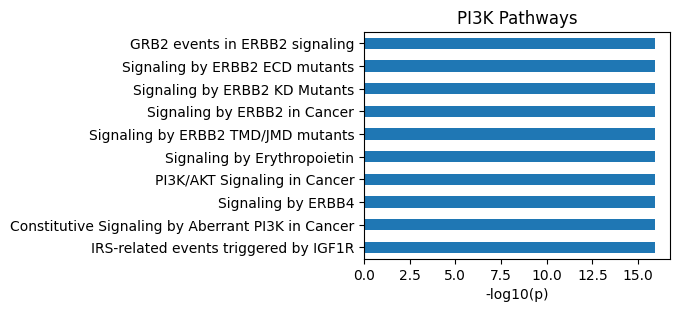

In [ ]:
plot_path(format_out)
plt.title('PI3K Pathways');

## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

<unknown>:9: SyntaxWarning: invalid escape sequence '\d'
<unknown>:9: SyntaxWarning: invalid escape sequence '\d'
<unknown>:9: SyntaxWarning: invalid escape sequence '\d'
<unknown>:9: SyntaxWarning: invalid escape sequence '\d'
